In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

from dualneuron.screening.sets import ImagenetImages, RenderedImages
from dualneuron.screening.run import activations

from pathlib import Path
import dualneuron
import numpy as np

import matplotlib.pyplot as plt

token = os.getenv("HF_TOKEN")
data_dir = os.getenv("DATA_DIR")

In [2]:
data = np.load(data_dir + "dryad/v4_imagenet_ordered_responses.npz")
indices = np.load(data_dir + "dryad/v4_imagenet_ordered_indices.npz")

model_name = "V4ColorTaskDriven"
package_dir = Path(dualneuron.__file__).parent
mask_path = package_dir / "twins" / model_name / "mask.npy"
mask = np.load(mask_path)

In [4]:
from scipy import stats
from tqdm import tqdm

skewness = {}

for key in tqdm(data.keys()):
    activations = data[key]
    skew = stats.skew(activations)
    skewness[key] = skew

sorted_neurons = sorted(
    skewness.items(), 
    key=lambda x: x[1], 
    reverse=True
)

print("Neurons ordered from most sparse to least sparse:")
print("-" * 50)
for neuron_id, skew in sorted_neurons[:10]:  # Show top 10
    print(f"Neuron: {neuron_id}, Skewness: {skew:.4f}")

ordered_neurons = [neuron_id for neuron_id, _ in sorted_neurons]

100%|██████████| 205/205 [00:10<00:00, 19.80it/s]

Neurons ordered from most sparse to least sparse:
--------------------------------------------------
Neuron: unit_23, Skewness: 5.6568
Neuron: unit_91, Skewness: 5.0384
Neuron: unit_231, Skewness: 4.7484
Neuron: unit_95, Skewness: 3.8190
Neuron: unit_52, Skewness: 3.6519
Neuron: unit_173, Skewness: 3.5973
Neuron: unit_60, Skewness: 3.2913
Neuron: unit_170, Skewness: 3.2756
Neuron: unit_298, Skewness: 3.1575
Neuron: unit_227, Skewness: 3.1509


In [5]:
highpoles = {}
num_imgs = 10

for key in tqdm(ordered_neurons):
    highpoles[key] = indices[key][-num_imgs:]

100%|██████████| 205/205 [00:24<00:00,  8.35it/s]


In [6]:
dset = ImagenetImages(
    data_dir=data_dir + "datasets",
    token=token,
    split='train',
    use_center_crop=True,
    use_resize_output=True,
    use_grayscale=False,
    use_normalize=False,
    use_mask=True,
    use_norm=False,
    mask=mask,
    num_channels=3,
    output_size=(224, 224),
    crop_size=236,
    bg_value=0.45,
    norm=None,
)

Resolving data files:   0%|          | 0/294 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/294 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/267 [00:00<?, ?it/s]

In [7]:
highpole_images = {}

for key in tqdm(highpoles.keys()):
    image_indices = highpoles[key]
    images = []
    for idx in image_indices:
        img, _ = dset[idx]
        images.append(img.permute(1, 2, 0))

    highpole_images[key] = np.stack(images) 

100%|██████████| 205/205 [00:45<00:00,  4.51it/s]


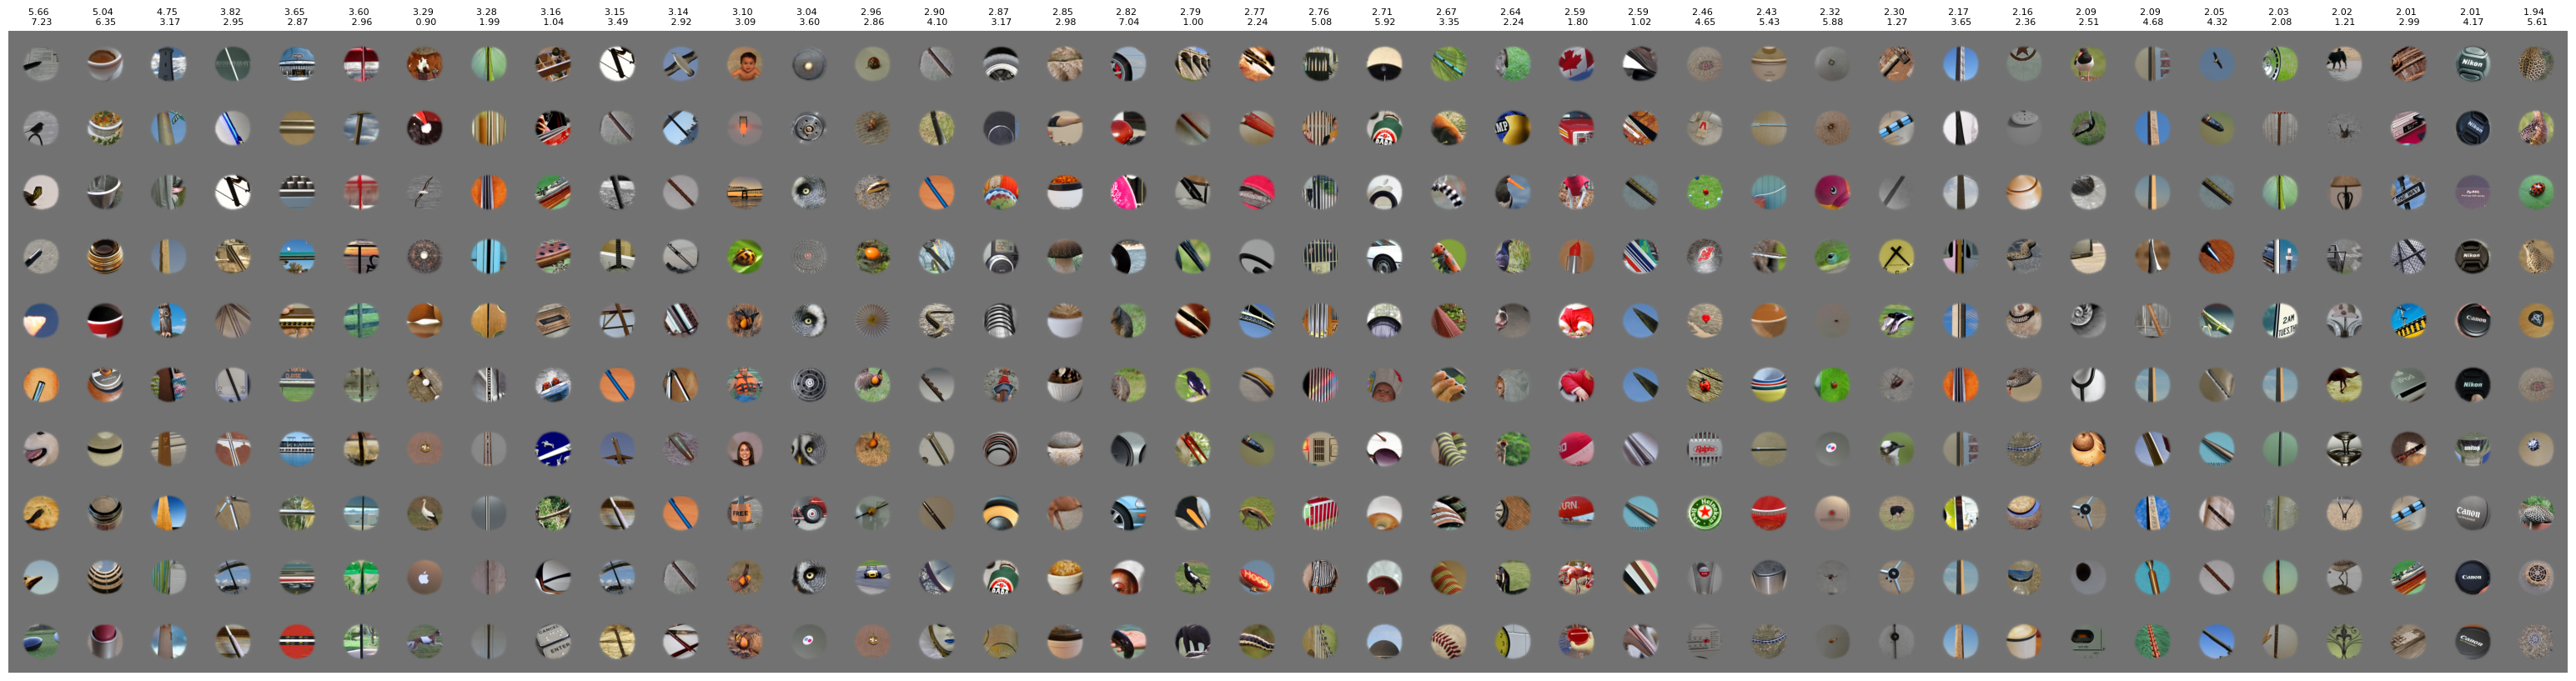

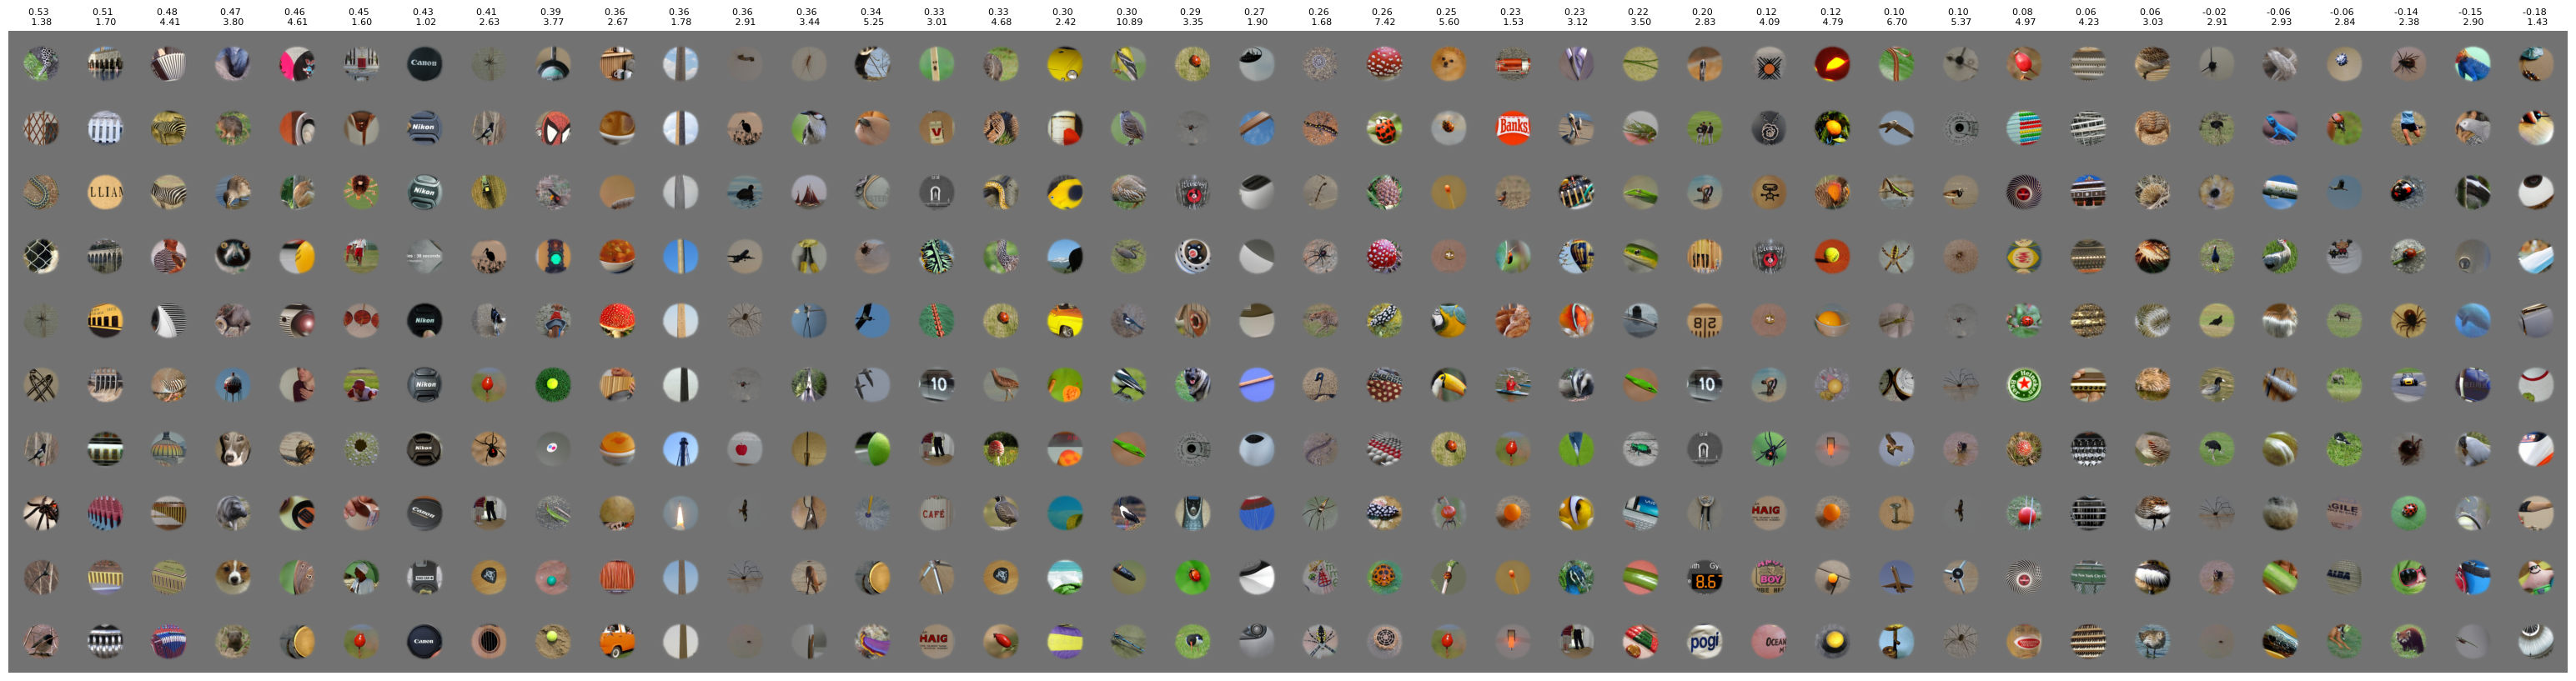

In [8]:
tail = 40
fig, axes = plt.subplots(num_imgs, tail, figsize=(0.99 * tail, num_imgs))

for i, neuron_id in enumerate(ordered_neurons[:tail]):
    images = highpole_images[neuron_id]
    skew = skewness[neuron_id]
    act = data[neuron_id][-1]

    for j, img in enumerate(images[:num_imgs]):
        if j == 0:
            axes[j, i].set_title(f"{skew:.2f} \n {act:.2f}", fontsize=8)
        axes[j, i].imshow(img)
        axes[j, i].axis('off')

plt.subplots_adjust(wspace=0., hspace=0.)
plt.show()

fig, axes = plt.subplots(num_imgs, tail, figsize=(0.99 * tail, num_imgs))

for i, neuron_id in enumerate(ordered_neurons[-tail:]):
    images = highpole_images[neuron_id]
    skew = skewness[neuron_id]
    act = data[neuron_id][-1]

    for j, img in enumerate(images[:num_imgs]):
        if j == 0:
            axes[j, i].set_title(f"{skew:.2f} \n {act:.2f}", fontsize=8)
        axes[j, i].imshow(img)
        axes[j, i].axis('off')

plt.subplots_adjust(wspace=0., hspace=0.)
plt.show()